In this post we'll look at a fourth-order equation describing the vibrations of clamped plates.
Fourth-order problems are much harder to discretize than second-order.
Here we'll get around that by using its dual or mixed form.
This will use some of the same techniques that we've already seen with the Stokes equations.
But it won't be a perfectly conforming discretization, and as a consequence we'll need some jump terms that ought to be familiar from the discontinuous Galerkin method.
Finally we'll compute some eigenfunctions of plate operator.
This will look similar to what we did with [Weyl's law](https://shapero.xyz/posts/weyls-law/) but with an extra mathematical subtlety.

Our starting point is linear elasticity.
Here we want to solve for the 3D displacement $u$ of the medium.
The first equation is momentum conservation:
$$\rho\ddot u = \nabla\cdot\sigma + f$$
where $\sigma$ is the stress tensor and $f$ the body forces.
To close the system, we need to supply a constitutive equation relating the stress tensor and the strain tensor
$$\varepsilon = \frac{1}{2}\left(\nabla u + \nabla u^*\right).$$
The most general linear constitutive equation we can write down is
$$\sigma = \mathscr C\,\varepsilon$$
where $\mathscr C$ is the rank-4 elasticity tensor.
We need that $\mathscr C$ maps symmetric tensors to symmetric tensors and that $\varepsilon:\mathscr C\varepsilon$ is always positive.
The equilibrium displacement of the medium is the minimizer of the energy functional
$$J(u) = \int_\Omega\left(\frac{1}{2}\sigma:\varepsilon + f\cdot u\right)\mathrm dx + \ldots$$
where the ellipses stand for various boundary forcings that we'll ignore.

For a medium that is homogeneous and isotropic, the elasticity tensor has to have the form
$$\mathscr C\,\varepsilon = 2\,\mu\,\varepsilon + \lambda\,\text{tr}(\varepsilon)I$$
where $\mu$ and $\lambda$ are the Lamé parameters.
As an aside, there are a mess of alternate forms of the elasticity equations.
The [wiki page](https://en.wikipedia.org/wiki/Lam%C3%A9_parameters) has a conversion table at the bottom.
Now take this with a grain of salt because I do fluid mechanics.
But if I were a solid mechanics kinda guy, this would embarrass me.
Get it together folks.

Plate theory is what you get when you assume the medium is thin along the vertical dimension and that this restricts the form that the displacements can take.
The first and most widely agreed-upon simplification is that the vertical displacement is some function $w$ of the horizontal coordinates $x$, $y$:
$$u_z = w(x, y).$$
From here we have to make additional assumptions about the horizontal displacements $u_x$ and $u_y$.
Different theories make different sets of assumptions.
The classical theory is the [Kirchoff-Love](https://en.wikipedia.org/wiki/Kirchhoff%E2%80%93Love_plate_theory) plate.
The Kirchoff theory assumes that any straight line that's perpendicular to the middle of the plate remains straight and perpendicular after deformation.
This theory has some deficiences, see for example [this paper](https://www-users.cse.umn.edu/~arnold//papers/rmkl.pdf).
But it's a good starting point for experimentation.
These assumptions let us write down the other components of the deformation in terms of $w$:
$$u_x = -z\frac{\partial w}{\partial x}, \quad u_y = -z\frac{\partial w}{\partial y}.$$
It's possible that $u_x$ and $u_y$ are also offset by in-plane displacements.
I'll assume that the boundary conditions make those equal to zero.
We can then work out what the displacement gradient is:
$$\nabla u = \left[\begin{matrix}-z\nabla^2 w & -\nabla w \\ +\nabla w^* & 0 \end{matrix}\right]$$
I'm being a little loose in my use of the gradient operator -- it's 3D on the left-hand side of this equation and 2D on the right.
Notice how the antisymmetric part of the displacement gradient is all in the $x-z$ and $y-z$ components.
When we symmetrize the displacement gradient, we get the strain tensor:
$$\varepsilon = -z\left[\begin{matrix}\nabla^2 w & 0 \\ 0 & 0\end{matrix}\right].$$
Now remember that the medium is a thin plate.
We can express the spatial domain as the product of a 2D footprint domain $\Phi$ and the interval $[-h / 2, +h / 2]$ where $h$ is the plate thickness.
The strain energy is then
$$\begin{align}
J(w) & = \int_\Phi\int_{-h/2}^{+h/2}\left(\mu z^2|\nabla^2 w|^2 + \frac{\lambda}{2} z^2|\Delta w|^2 + fw\right)\mathrm dz\;\mathrm dx\\
 & = \int_\Phi\left\{\frac{h^3}{24}\left(2\mu|\nabla ^2 w|^2 + \lambda|\Delta w|^2\right) + hfw\right\}\mathrm dx
\end{align}.$$
Here I've used the fact that $\text{tr}(\nabla^2w) = \Delta w$ where $\Delta$ is the Laplace operator.
In a gross abuse of notation I'll write this as
$$J(w) = \int_\Omega\left(\frac{1}{2}\mathscr C\nabla^2w :\nabla^2 w + fw\right)h\,\mathrm dx$$
where $\mathscr C$ is an elasticity tensor.
We'll need the explicit form
$$\mathscr C\kappa = \frac{h^2}{12}\left(2\,\mu\,\kappa + \lambda\,\text{tr}(\kappa)\,I\right)$$
in a moment.

We can't discretize this problem right away using a conventional finite element basis.
The usual piecewise polynomial basis functions are differentiable and piecewise continuous across cell edges.
A conforming basis for a minimization problem involving 2nd-order derivatives would need to instead by continuously differentiable.
It's much harder to come up with $C^1$ bases.

We have a few ways out.
1. Use a $C^1$ basis like [Argyris](https://defelement.org/elements/argyris.html) or [Hsieh-Clough-Tocher](https://defelement.org/elements/hsieh-clough-tocher.html).
This approach makes forming the problem easy, but applying boundary conditions hard.
[Kirby and Mitchell (2018)](https://dl.acm.org/doi/pdf/10.1145/3361745) implemented the Argyris element in Firedrake but had to use Nitsche's method to enforce the boundary conditions.
1. Use $C^0$ elements and discretize the second derivatives using an interior penalty formulation of the problem.
This approach is analogous to discretizing a 2nd-order elliptic problem using DG elements.
Forming the problem is harder but applying the boundary conditions is easier.
[Bringmann et al. (2023)](https://doi.org/10.1515/jnma-2023-0028) work out the exact form the interior penalty parameters necessary to make the discrete form work right.
1. Use the mixed or dual form of the problem, which introduces the moment tensor explicitly as an unknown.
Discretize it with the Hellan-Herrmann-Johnson or HHJ element.
[Arnold and Walker (2020)](https://doi.org/10.1137/19M1288723) describe this formulation of the problem in more detail.

In the following, I'll take the third approach.
The dual form of the problem introduces the moment tensor, which in another gross abuse of notation I'll write as $\sigma$, explicitly as an unknown.
We then add the constraint that $\sigma = \mathscr C\nabla^2 w$.
But switching to the dual form of the problem inverts constitutive relations, so we instead enforce
$$\nabla^2w = \mathscr A\sigma$$
where $\mathscr A$ is the inverse to $\mathscr C$.
If $\mathscr C$ is like the elasticity tensor in 3D, then $\mathscr A$ is like the compliance tensor.
Because we'll need it later, the explicit form of the compliance tensor is
$$\mathscr A\sigma = \frac{6}{h^2\mu}\left(\sigma - \frac{\lambda}{2(\mu + \lambda)}\text{tr}(\sigma)I\right).$$
The full Lagrangian for the dual form is
$$L(w, \sigma) = \int_\Omega\left(\frac{1}{2}\mathscr A\sigma : \sigma - \sigma : \nabla^2 w - fw\right)h\,\mathrm dx.$$
Here the displacement $w$ acts like a multiplier enforcing the constraint that $\nabla\cdot\nabla\cdot\sigma + f = 0$.

To get a conforming discretization of the dual problem, we'd still need the basis functions for the displacements to have continuous derivatives.
That's exactly what we were trying to avoid by using the dual form in the first place.
At the same time, we don't assume any continuity properties of the moments.
We can work around this problem by relaxing the continuity requirements for the displacements while strengthening them for the moments.
The Hellann-Herrmann-Johnson element discretizes the space of symmetric tensor fields with just enough additional regularity to make this idea work.
The HHJ element has *normal-normal* continuity: the quantity $n\cdot\sigma n$ is continuous across cell boundaries.
The tangential and mixed components are unconstrained.
This extra continuity is enough to let us use the conventional Lagrange finite elements for the displacements as long as we add a correction term to the Lagrangian:
$$\ldots + \sum_\Gamma\int_\Gamma (n\cdot\sigma n)\,\left[\!\!\left[\frac{\partial w}{\partial n}\right]\!\!\right]h\,\mathrm dS$$
where $\Gamma$ are all the edges of the mesh and the double square bracket denotes the jump of a quantity across a cell boundary.
What is especially nice about the HHJ element is that this correction is all we need to add; there are no mesh-dependent penalty factors.

### Experiments

First let's try and solve a plate problem using simple input data.
We'll set all the physical constants equal to 1 but you can look these up for the material of your fancy.

In [1]:
import firedrake
from firedrake import Constant, inner, tr, dot, grad, dx, ds, dS, avg, jump
import ufl

In [2]:
f = Constant(1.0)
h = Constant(1.0)
μ = Constant(1.0)
λ = Constant(1.0)

The code below creates the dual form of the problem using the formula I wrote down above for the explicit form of the compliance tensor.
Lord Jesus I hope I did all that algebra correct.

In [3]:
def form_hhj_lagrangian(z, f, h, μ, λ):
    mesh = ufl.domain.extract_unique_domain(z)
    w, σ = firedrake.split(z)
    I = firedrake.Identity(2)
    n = firedrake.FacetNormal(mesh)

    Aσ = 6 / (h**2 * μ) * (σ - λ / (2 * (μ + λ)) * tr(σ) * I)

    L_cells = (0.5 * inner(Aσ, σ) - inner(σ, grad(grad(w))) + f * w) * dx
    L_facets = avg(inner(n, dot(σ, n))) * jump(grad(w), n) * dS
    L_boundary = inner(n, dot(σ, n)) * inner(grad(w), n) * ds
    return L_cells + L_facets + L_boundary

The right degrees are $p + 1$ for the displacements and $p$ for the moments.

In [4]:
p = 1
cg = firedrake.FiniteElement("CG", "triangle", p + 1)
hhj = firedrake.FiniteElement("HHJ", "triangle", p)

Here we'll work on the unit square.
An interesting feature of plate problems is that they don't become much easier to solve analytically on the unit square by separation of variables because of the mixed derivatives.
The eigenfunctions of the biharmonic operator (we'll get to them below) are easier to derive on the circle than the square.

In [5]:
n = 64
mesh = firedrake.UnitSquareMesh(n, n, diagonal="crossed")
Q = firedrake.FunctionSpace(mesh, cg)
Σ = firedrake.FunctionSpace(mesh, hhj)
Z = Q * Σ

In [6]:
z = firedrake.Function(Z)
L = form_hhj_lagrangian(z, f, h, μ, λ)
F = firedrake.derivative(L, z)

For plate problems, we almost always have some Dirichlet boundary condition
$$w|_{\partial\Omega} = w_0.$$
Since the problem is fourth-order, we need to supply more boundary conditions than we do for, say, the diffusion equation.
There are two kinds.
The first is the *clamped* boundary condition:
$$\frac{\partial w}{\partial n} = 0.$$
The second is the simply-supported boundary condition:
$$n\cdot\sigma n = 0.$$
Before I started writing this I was dreading how I was going to deal with either one.
I was shocked at how easy it was to get both using the HHJ element.
First, let's see what happens if we only enforce zero displacement at the boundary.

In [7]:
bc = firedrake.DirichletBC(Z.sub(0), 0, "on_boundary")
firedrake.solve(F == 0, z, bc)

In [8]:
w, σ = z.subfunctions
n = firedrake.FacetNormal(mesh)
dw_dn = inner(grad(w), n)
σ_nn = inner(dot(σ, n), n)

boundary_slope = firedrake.assemble(dw_dn ** 2 * ds)
boundary_stress = firedrake.assemble(σ_nn ** 2 * ds)
print(f"Integrated boundary slope:  {boundary_slope}")
print(f"Integrated boundary moment: {boundary_stress}")

Integrated boundary slope:  2.2011469921934104e-10
Integrated boundary moment: 0.004669439784520921


So it looks like the clamped boundary condition is natural with HHJ elements.
We can confirm that by looking at a 3D plot.

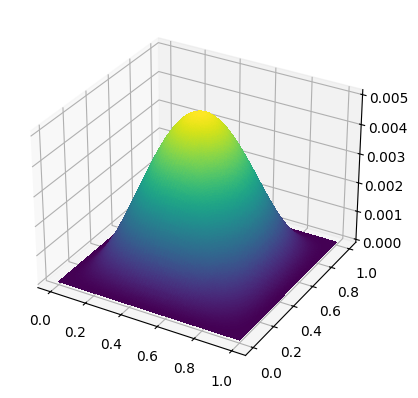

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
firedrake.trisurf(w, axes=ax);

Now let's see what happens if we apply a Dirichlet boundary condition to the moment part of the solution.

In [10]:
simply_supported_bc = firedrake.DirichletBC(Z.sub(1), 0, "on_boundary")
firedrake.solve(F == 0, z, bcs=[bc, simply_supported_bc])

In [11]:
w, σ = z.subfunctions
n = firedrake.FacetNormal(mesh)
dw_dn = inner(grad(w), n)
σ_nn = inner(dot(σ, n), n)

boundary_slope = firedrake.assemble(dw_dn ** 2 * ds)
boundary_stress = firedrake.assemble(σ_nn ** 2 * ds)
print(f"Integrated boundary slope:  {boundary_slope}")
print(f"Integrated boundary moment: {boundary_stress}")

Integrated boundary slope:  0.006015973809994057
Integrated boundary moment: 0.0


Now the boundary stresses are zero and so the boundary slopes are unconstrained.

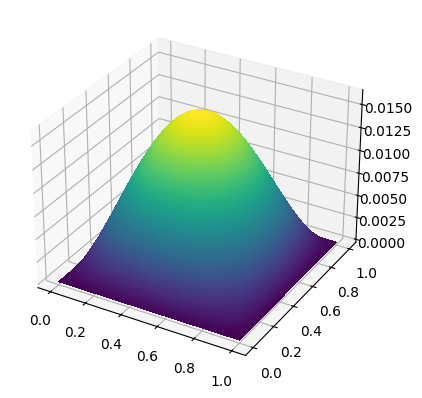

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
firedrake.trisurf(w, axes=ax);

The reason why this works is that the boundary degrees of freedom for the HHJ element are the normal-normal stress components.
So if we set all of those to zero, we get simply-supported boundary conditions.
This is analogous to the simpler setting of $H(\text{div})$ elements for vector fields having normal continuity.
We can easily enforce boundary conditions like $u\cdot n = 0$ by setting the right degrees of freedom to zero.

We have to work a lot harder to get the boundary conditions right using other finite element bases.
For example, the Argyris element has both value and derivative degrees of freedom at the mesh vertices.
We can't set the boundary values alone in the same way.
In order to set the boundary values with Argyris elements, [Kirby and Mitchell](https://arxiv.org/pdf/1808.05513) had to use Nitsche's method.
The Hsieh-Clough-Tocher (HCT) element makes it easy to use clamped boundary conditions but simply-supported is harder.
The fact that both types are relatively easy with HHJ is a definite advantage, although it has more total degrees of freedom than HCT.

### Eigenfunctions

The eigenfunctions of the plate problem, also known as [Chladni patterns](https://en.wikipedia.org/wiki/Ernst_Chladni#Chladni_figures), have a fascinating history.
[This review](https://doi.org/10.1137/100804036) is good reading.
Here I'll show the first few eigenfunctions in a square with simply-supported boundary conditions.

In [13]:
A = firedrake.derivative(F, z)

w, σ = firedrake.split(z)
J = 0.5 * w**2 * dx
M = firedrake.derivative(firedrake.derivative(J, z), z)

bcs = [bc, simply_supported_bc]
problem = firedrake.LinearEigenproblem(A, M, bcs=bcs, restrict=True)

Note the $M$ matrix that we supplied above.
We've looked at generalized eigenvalue problems before, like in the post on [Weyl's law](https://shapero.xyz/posts/weyls-law/).
In that setting we were solving eigenvalue problems of the form
$$A\phi = \lambda M\phi$$
where $M$ was some symmetric positive-definite matrix instead of the identity.
In those cases we always used the mass matrix.
For saddle-point eigenvalue problems, we're often using something that is no longer definite.
Here the form we want is instead
$$\left[\begin{matrix} A & B^* \\ B & 0\end{matrix}\right]\left[\begin{matrix}\sigma \\ w\end{matrix}\right] = \lambda\left[\begin{matrix} 0 & 0 \\ 0 & M\end{matrix}\right]\left[\begin{matrix}\sigma \\ w\end{matrix}\right]$$
where $M$ is the mass matrix for the displacement block.

In [14]:
num_values = 40
opts = {
    "solver_parameters": {
        "eps_gen_hermitian": None,
        "eps_target_real": None,
        "eps_smallest_real": None,
        "st_type": "sinvert",
        "st_ksp_type": "gmres",
        "st_pc_type": "lu",
        "st_pc_factor_mat_solver_type": "mumps",
        "eps_tol": 1e-8,
    },
    "n_evals": num_values,
}
eigensolver = firedrake.LinearEigensolver(problem, **opts)
num_converged = eigensolver.solve()
print(f"Number of converged eigenfunctions: {num_converged}")

Number of converged eigenfunctions: 42


The plot below shows the nodal lines of the eigenfunctions.
Many of them come in pairs due to the axis-flipping symmetry.
These are the patterns that so fascinated Chladni and others.

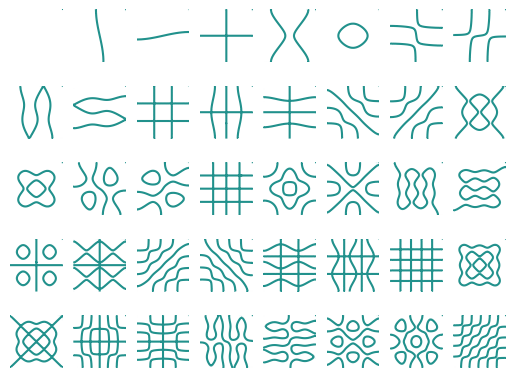

In [15]:
ϕs = [eigensolver.eigenfunction(n)[0].sub(0) for n in range(num_values)]
fig, axes = plt.subplots(nrows=5, ncols=8, sharex=True, sharey=True)
for ax in axes.flatten():
    ax.set_aspect("equal")
    ax.set_axis_off()

levels = [-10, 0, 10]
for ax, ϕ in zip(axes.flatten(), ϕs):
    firedrake.tricontour(ϕ, levels=levels, axes=ax)